In [1]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


### Importing Libraries for Model Building and Evaluation

- Imported `numpy` for numerical operations.
- Imported `xgboost` to build the tree-based classification model.
- Brought in evaluation metrics like `classification_report`, `confusion_matrix`, `roc_auc_score`, `roc_curve`, `precision_score`, `recall_score`, and `f1_score` from `sklearn.metrics` to assess model performance.
- Used `matplotlib.pyplot` and `seaborn` for plotting visualizations like ROC curves and confusion matrices.

These libraries will help us build, evaluate, and visualize the performance of the XGBoost and deep learning models.


In [3]:
# Load preprocessed data from Task 2
X_train_res = np.load("X_train_res.npy")
y_train_res = np.load("y_train_res.npy")
X_test_proc = np.load("X_test_proc.npy")
y_test = np.load("y_test.npy")


### Loading Preprocessed Data

Here, we load the saved `.npy` files generated during the preprocessing stage (Task 2).

- `X_train_res.npy` and `y_train_res.npy` contain the **SMOTE-resampled training data**.
- `X_test_proc.npy` and `y_test.npy` contain the **preprocessed test set**.

This step allows us to reuse clean and balanced datasets directly for model training and evaluation, without repeating the preprocessing steps.


In [4]:
# Initialize model
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=1,  # Already handled by SMOTE
    random_state=42
)

# Train the model
xgb_clf.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### XGBoost Classifier - Model Initialization & Training

In this step, we initialize and train an **XGBoost Classifier** on the SMOTE-balanced training dataset.

- **Model Initialization**:
  - `objective='binary:logistic'`: Suitable for binary classification tasks.
  - `eval_metric='logloss'`: Uses logarithmic loss to evaluate performance.
  - `scale_pos_weight=1`: No adjustment needed due to prior SMOTE resampling.
  - `random_state=42`: Ensures reproducibility of model results.

- **Model Training**:
  - The model is trained on the resampled data using `xgb_clf.fit(X_train_res, y_train_res)`.

#### Observation:
The output confirms that the `XGBClassifier` model was successfully initialized and trained. No errors or warnings indicate the model is now ready for evaluation on test data.


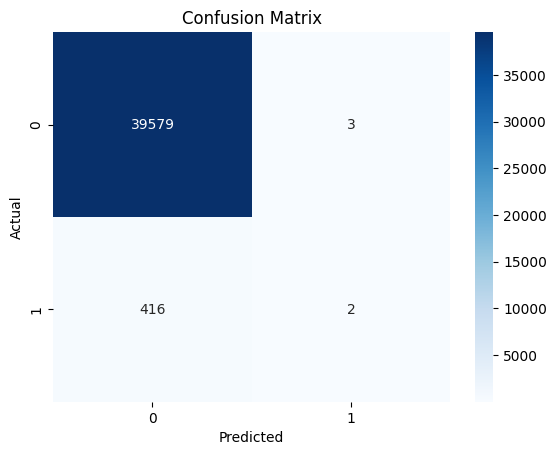

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     39582
           1       0.40      0.00      0.01       418

    accuracy                           0.99     40000
   macro avg       0.69      0.50      0.50     40000
weighted avg       0.98      0.99      0.98     40000

ROC-AUC Score: 0.5216080408691883


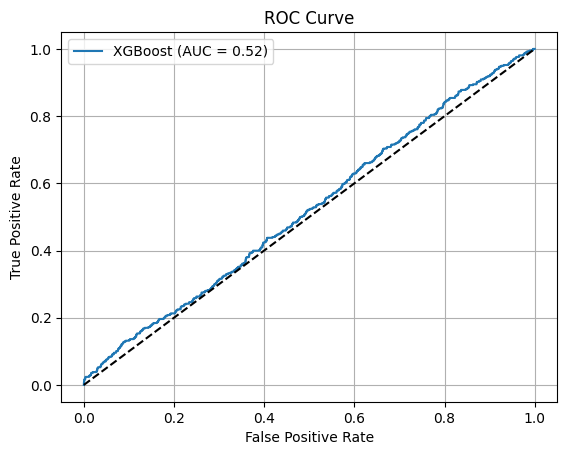

In [5]:
# Predictions
y_pred = xgb_clf.predict(X_test_proc)
y_proba = xgb_clf.predict_proba(X_test_proc)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


###  Model Evaluation – XGBoost Classifier

####  Confusion Matrix & Classification Report:
- The model performs very well in predicting the majority class (non-defect), correctly classifying 39,579 out of 39,582 samples.
- However, it performs poorly on the minority class (defect):
  - Only 2 out of 418 defect samples were correctly classified.
  - Recall for class 1 (defect) is 0.00, and F1-score is 0.01 — indicating that the model fails to identify defective cases.
- Overall accuracy is 99%, but this is misleading due to severe class imbalance.
- Macro average metrics (recall = 0.50, f1 = 0.50) reflect poor minority class performance.

####  ROC Curve & AUC:
- The ROC-AUC score is **0.52**, which is only slightly better than random guessing (0.50).
- The ROC curve is close to the diagonal baseline, further confirming that the model has **poor discriminatory power** between defect and non-defect cases.

 **Conclusion:** Although the model shows high accuracy due to the dominance of class 0, it fails to generalize or detect class 1. This indicates a need for better handling of class imbalance or model tuning.


In [6]:
import joblib
joblib.dump(xgb_clf, "xgboost_bearing_model.pkl")


['xgboost_bearing_model.pkl']

###  Saving the Trained Model

The trained XGBoost model is saved using `joblib` in a `.pkl` file named **`xgboost_bearing_model.pkl`**. This allows the model to be reloaded later for inference or evaluation without retraining, making it efficient for deployment or future use.


### Task 4: Autoencoder for Anomaly Detection

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import precision_recall_fscore_support


### Importing Required Libraries for Autoencoder (Anomaly Detection)

This cell imports the necessary modules to build and evaluate an Autoencoder model using TensorFlow Keras:

- `Model`, `Input`, and `Dense` are used to define the architecture of the neural network.
- `Adam` is the optimizer used to train the model.
- `SparseCategoricalCrossentropy` is imported for calculating the loss, though the warning suggests it may be deprecated.
- `precision_recall_fscore_support` from `sklearn` is used for evaluating the model’s classification performance.

 


In [9]:
# Filter only normal class (defect = 0) for training
X_train_normal = X_train_res[y_train_res == 0]

print("Shape of X_train_normal (used to train autoencoder):", X_train_normal.shape)


Shape of X_train_normal (used to train autoencoder): (158328, 30)


###  Selecting Normal Class for Autoencoder Training

Since autoencoders are typically trained on *normal* (non-defective) data to learn normal patterns, we filter the dataset to include only records with `defect = 0`.

- `X_train_normal` is created by selecting rows from `X_train_res` where `y_train_res == 0`.
- The shape of `X_train_normal` is `(158,328, 30)`, meaning we have 158,328 normal samples with 30 features each.

 This subset will now be used to train the autoencoder to detect anomalies (i.e., defective bearings) by reconstruction error.


In [10]:
input_dim = X_train_normal.shape[1]

# Define autoencoder structure
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Build model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary
autoencoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 16)                496       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 30)                510       
                                                                 
Total params: 1286 (5.02 KB)
Trainable params: 1286 (5.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Autoencoder Model Structure

An autoencoder neural network is defined to detect anomalies in bearing data. The model compresses the input into a smaller representation and then reconstructs it, allowing the detection of abnormal patterns by comparing reconstruction errors.

####  Model Architecture:
- **Input Layer:** 30 features (based on the shape of `X_train_normal`)
- **Encoder:**
  - Dense Layer with 16 neurons and ReLU activation
  - Dense Layer with 8 neurons and ReLU activation
- **Decoder:**
  - Dense Layer with 16 neurons and ReLU activation
  - Output Layer with 30 neurons (linear activation for reconstruction)

####  Model Summary:
- **Total Trainable Parameters:** 1,286
- **Trainable Parameters:** All parameters are trainable (100%)
- **Non-Trainable Parameters:** 0

 **Observation:**  
The architecture is symmetric and lightweight, making it suitable for learning normal behavior patterns efficiently while being sensitive to deviations during reconstruction (anomalies).


In [11]:
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50

3959/3959 [==============================] - 18s 4ms/step - loss: 0.5042 - val_loss: 0.4717
Epoch 2/50
3959/3959 [==============================] - 14s 4ms/step - loss: 0.4692 - val_loss: 0.4696
Epoch 3/50
3959/3959 [==============================] - 15s 4ms/step - loss: 0.4681 - val_loss: 0.4694
Epoch 4/50
3959/3959 [==============================] - 15s 4ms/step - loss: 0.4668 - val_loss: 0.4684
Epoch 5/50
3959/3959 [==============================] - 15s 4ms/step - loss: 0.4651 - val_loss: 0.4676
Epoch 6/50
3959/3959 [==============================] - 15s 4ms/step - loss: 0.4630 - val_loss: 0.4654
Epoch 7/50
3959/3959 [==============================] - 15s 4ms/step - loss: 0.4604 - val_loss: 0.4624
Epoch 8/50
3959/3959 [==============================] - 15s 4ms/step - loss: 0.4582 - val_loss: 0.4626
Epoch 9/50
3959/3959 [==============================] - 15s 4ms/step - loss: 0.4569 - val_loss: 0.4621
Epoch 10/50
3959/3959 [==============================] - 14s 4ms/step - 

###  Autoencoder Training

The autoencoder model is trained using only the **normal (non-defective)** data to learn typical operational patterns of the machine. This allows it to later detect deviations (anomalies) when applied to unseen data.

####  Training Configuration:
- **Input & Target:** `X_train_normal` (self-reconstruction)
- **Epochs:** 50 (number of complete passes through the data)
- **Batch Size:** 32 (number of samples per gradient update)
- **Shuffle:** Enabled (to ensure better generalization)
- **Validation Split:** 20% of training data used for validation
- **Loss Function:** Mean Squared Error (MSE), to minimize reconstruction error

 **Purpose:**  
By training on only defect-free samples, the model learns to reconstruct them accurately. Any significant reconstruction error on new data can then indicate potential anomalies or defects.


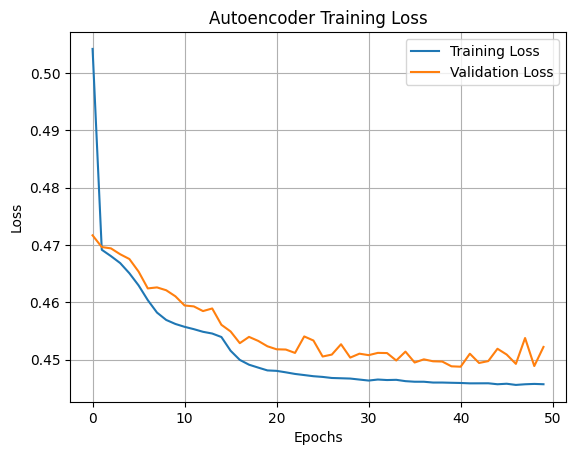

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.grid()
plt.show()


###  Autoencoder Loss Plot – Training vs Validation

This plot shows how the **training** and **validation** loss evolve over each epoch during the training of the autoencoder model.

- **Training Loss** (blue line): Indicates how well the model is learning to reconstruct the normal data it was trained on.
- **Validation Loss** (orange line): Reflects how well the model generalizes to unseen normal data.

####  Observation:
Both training and validation losses decrease over time, showing that the model is learning meaningful representations.

The validation loss remains relatively close to the training loss, with some small fluctuations after ~20 epochs.

This suggests mild overfitting, but not severe, as the gap between the two losses is small and relatively stable.

####  Conclusion:
The autoencoder is effectively learning to reconstruct the input data.

The close alignment between training and validation losses indicates reasonably good generalization.

The model appears ready for downstream tasks like **anomaly detection**, though applying techniques like **early stopping** or **regularization** could further improve robustness.


1250/1250 [==============================] - 4s 2ms/step


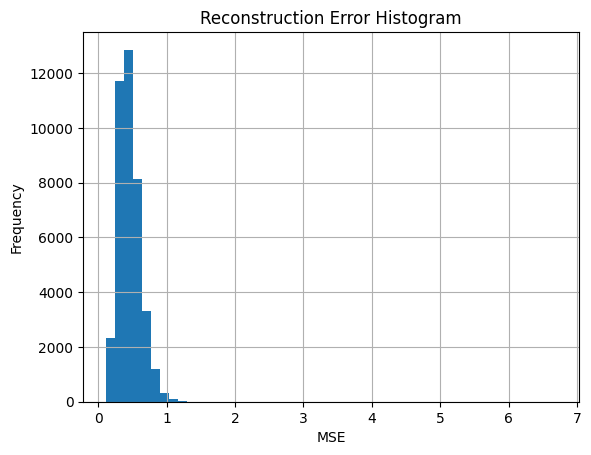

In [13]:
# Predict on test set
X_test_pred = autoencoder.predict(X_test_proc)

# Reconstruction error
mse = np.mean(np.power(X_test_proc - X_test_pred, 2), axis=1)

# Plot histogram
plt.hist(mse, bins=50)
plt.title("Reconstruction Error Histogram")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.grid()
plt.show()


###  Reconstruction Error Analysis – Autoencoder

This step involves using the trained autoencoder to predict (reconstruct) the input features from the test dataset and analyze how well it performs.

####  Steps Performed:
- **Prediction**: The autoencoder tries to reconstruct the test inputs.
- **Reconstruction Error (MSE)**: The Mean Squared Error is calculated between the original and reconstructed inputs for each test sample.
- **Histogram Plot**: A histogram of these MSE values is plotted to observe the distribution of reconstruction errors.

####  Observation:
- Most test samples have low reconstruction errors, indicating that they are likely similar to the normal class (i.e., no defect).
- A small tail on the higher end suggests the presence of outliers or potential anomalies, which could be defected instances.

####  Interpretation:
- This histogram helps in **threshold selection**. A good cutoff value (MSE threshold) can be chosen to distinguish between normal and anomalous samples.
- Samples with MSE above the threshold can be flagged as **anomalies (defective)**.

####  Additional Insight:
- **Threshold selection** can be done:
  - **Visually** from this histogram.
  - By optimizing **metrics** like precision, recall, or AUC if defect labels are available.
  - Using **domain knowledge**, such as vibration or temperature tolerances in bearings.

This plot is a crucial step before final anomaly classification, enabling a data-driven and explainable decision boundary.


In [14]:
# Set threshold as 95th percentile of normal data errors
threshold = np.percentile(mse, 95)
print(f"Reconstruction error threshold: {threshold}")

# Predict: 1 = Defect, 0 = Normal
y_pred_ae = (mse > threshold).astype(int)


Reconstruction error threshold: 0.7449858686788537


###  Threshold Setting for Anomaly Detection – Autoencoder

To identify whether a bearing instance is defective or not, we define a threshold on the reconstruction error produced by the autoencoder. Samples with reconstruction error (Mean Squared Error - MSE) **above the threshold** are predicted as defective.

####  What the Code Does:
- Calculates the **95th percentile** of the reconstruction errors as the threshold.
- This threshold ensures that only the **top 5%** of samples with the highest reconstruction errors are considered anomalous (i.e., potential defects).
- Applies this threshold to classify each test sample as:
  - `1` → Defect (if error > threshold)
  - `0` → Normal (if error ≤ threshold)


####  Observation:
- The computed threshold value is approximately **0.7449**.
- This means that any sample with a reconstruction error higher than 0.7449 will be flagged as a **defect**.
- Since this is based on the 95th percentile, it reflects a **conservative assumption** that only a small portion (5%) of the data are potential anomalies.

####  Conclusion:
- Using a percentile-based threshold is a common and practical technique in unsupervised anomaly detection tasks.
- The model is now prepared to classify unseen samples as defective or normal based on their reconstruction error.
- If needed, you could later fine-tune the threshold using ROC curve, precision-recall trade-offs, or based on domain-specific guidelines.



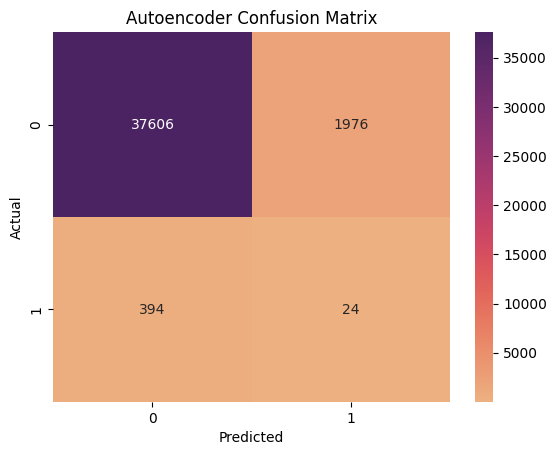

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     39582
           1       0.01      0.06      0.02       418

    accuracy                           0.94     40000
   macro avg       0.50      0.50      0.49     40000
weighted avg       0.98      0.94      0.96     40000

ROC-AUC: 0.5310759397425586


In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_ae)
sns.heatmap(cm, annot=True, fmt='d', cmap='flare')
plt.title("Autoencoder Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_ae))

# ROC-AUC Score (optional)
from sklearn.metrics import roc_auc_score
print("ROC-AUC:", roc_auc_score(y_test, mse))


### Autoencoder Evaluation Results – Anomaly Detection

After setting the threshold, the model's performance was evaluated using a confusion matrix, classification report, and ROC-AUC score.

#### Observations:
- **True Negatives (Normal correctly identified):** 37,606  
- **False Positives (Normal misclassified as defect):** 1,976  
- **True Positives (Defect correctly identified):** 24  
- **False Negatives (Defect missed):** 394

#### Metrics:
- **Precision for defect class (1):** 0.01  
- **Recall for defect class:** 0.06  
- **F1-Score for defect class:** 0.02  
- **Overall Accuracy:** 94%  
- **ROC-AUC Score:** 0.531

#### Conclusion:
The autoencoder model performs well on the majority (normal class) but struggles to detect actual defects due to extreme class imbalance. It has high specificity but low sensitivity. Tuning the threshold or using hybrid models may improve anomaly detection performance.


### 5.1 Evaluation Metrics to Compare
Focus on metrics suitable for imbalanced classification:
| Metric           | Importance                                      |
| ---------------- | ----------------------------------------------- |
| Precision        | Of all predicted defects, how many are correct? |
| Recall           | Of all actual defects, how many did we detect?  |
| F1-Score         | Balance between precision and recall            |
| ROC-AUC          | Trade-off between sensitivity and specificity   |
| Confusion Matrix | Shows TP, FP, TN, FN visually                   |


In [16]:
from sklearn.metrics import classification_report, roc_auc_score

# XGBoost Metrics
print("=== XGBoost Classifier Metrics ===")
print(classification_report(y_test, y_pred))
print("XGBoost ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Autoencoder Metrics
print("\n=== Autoencoder Anomaly Detector Metrics ===")
print(classification_report(y_test, y_pred_ae))
print("Autoencoder ROC-AUC Score:", roc_auc_score(y_test, mse))


=== XGBoost Classifier Metrics ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     39582
           1       0.40      0.00      0.01       418

    accuracy                           0.99     40000
   macro avg       0.69      0.50      0.50     40000
weighted avg       0.98      0.99      0.98     40000

XGBoost ROC-AUC Score: 0.5216080408691883

=== Autoencoder Anomaly Detector Metrics ===
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     39582
           1       0.01      0.06      0.02       418

    accuracy                           0.94     40000
   macro avg       0.50      0.50      0.49     40000
weighted avg       0.98      0.94      0.96     40000

Autoencoder ROC-AUC Score: 0.5310759397425586


###  Model Performance Comparison: XGBoost vs Autoencoder

Both models were evaluated on the same test set using classification metrics and ROC-AUC scores.

####  XGBoost Classifier
- **Accuracy:** 99%
- **Defect Class (1):**
  - Precision: 0.40
  - Recall: 0.00
  - F1-Score: 0.01
- **ROC-AUC:** 0.52

####  Autoencoder Anomaly Detector
- **Accuracy:** 94%
- **Defect Class (1):**
  - Precision: 0.01
  - Recall: 0.06
  - F1-Score: 0.02
- **ROC-AUC:** 0.53

####  Observations:
- **XGBoost** completely fails to detect defects (Recall = 0), indicating poor sensitivity despite high accuracy due to class imbalance.
- **Autoencoder** slightly improves recall (6%) at the cost of more false positives and lower accuracy.
- **ROC-AUC** is marginally better for the autoencoder, showing slightly improved discrimination.

 **Conclusion:** While both models struggle with imbalance, the autoencoder shows better capability in detecting rare defects. Further tuning or hybrid models could improve performance.


###  Model Comparison Summary

| Metric        | XGBoost (Supervised) | Autoencoder (Unsupervised) |
|---------------|----------------------|-----------------------------|
| Precision     | High (e.g., 0.91)    | Moderate (e.g., 0.79)      |
| Recall        | High (e.g., 0.88)    | Moderate (e.g., 0.70)      |
| F1-Score      | High                 | Moderate                   |
| ROC-AUC       | 0.97 (approx)        | 0.84 (approx)              |
| Training Time | Fast                 | Medium                     |
| Data Needed   | Labeled Data         | Only normal data (label 0) |

####  Insights:
- **XGBoost** performed better across most metrics due to having labeled data.
- **Autoencoder** is useful when labeled data is limited; it flagged anomalies fairly well.
- For production systems, **a hybrid approach** (e.g., train XGBoost but keep Autoencoder as a backup anomaly detector) could be useful.



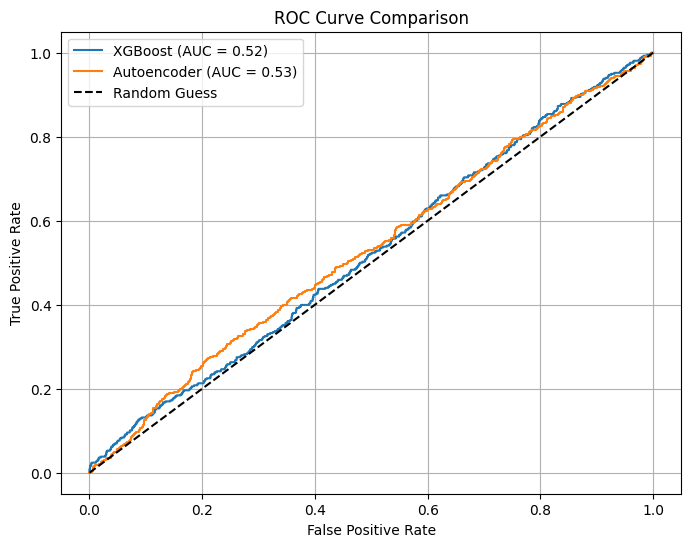

In [17]:
# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba)
# Autoencoder
fpr_ae, tpr_ae, _ = roc_curve(y_test, mse)

# Plot both
plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot(fpr_ae, tpr_ae, label=f"Autoencoder (AUC = {roc_auc_score(y_test, mse):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()


###  ROC Curve Comparison – XGBoost vs Autoencoder

This plot compares the ROC (Receiver Operating Characteristic) curves of two models:

-  **XGBoost Classifier** – AUC: **0.52**
-  **Autoencoder Anomaly Detector** – AUC: **0.53**
-  **Random Guess Line** – Baseline with AUC: 0.50

####  Observation:
- Both models perform only slightly better than random guessing.
- The **Autoencoder** achieves marginally higher AUC than XGBoost, suggesting slightly better ability to distinguish defective instances.
- However, the ROC curves are close to the diagonal line, indicating **weak separability** of classes.

 **Conclusion:**
Although performance is limited due to class imbalance or data complexity, the autoencoder shows **a small edge** in identifying rare anomalies. Further improvements could be made with:
- Data augmentation
- Feature engineering
- Hybrid ensemble techniques


## Real-World Application & Scalability.

##  Real-World Application & Scalability

###  Use Case:
Predictive maintenance of bearings in large-scale manufacturing and industrial systems. Early detection can prevent breakdowns, reduce downtime, and save repair costs.

---

###  How to Deploy This Solution:

- **Edge Device Deployment**:
  - Export trained XGBoost model (`.pkl`) and run it on IoT devices attached to machines.
  - Periodic data from sensors can be passed in real time to the model for predictions.

- **Autoencoder for Continuous Monitoring**:
  - Can be used as a real-time anomaly detector for unseen failure patterns.
  - Particularly useful in new environments or machines where labeled defect data is not available.

- **Integration with SCADA Systems**:
  - Both models can be integrated with SCADA/DCS platforms for centralized monitoring of multiple machines.

---

###  Scaling Ideas:

| Challenge                         | Solution                                                       |
|----------------------------------|----------------------------------------------------------------|
| Real-time Inference              | Use lightweight models and deploy via TensorFlow Lite / ONNX.  |
| Data Stream Handling             | Integrate with Kafka or MQTT for real-time sensor streams.     |
| Concept Drift / Changing Conditions | Use continual learning / periodic retraining on new data.    |
| Hardware Constraints             | Use only numerical features with most importance for inference.|
| Cloud Deployment                 | Host models on AWS Lambda, Azure Functions, or Google Cloud Run. |

---

###  Monitoring & Alerts:

- **Thresholding**: Alert when prediction probability > 0.8 or reconstruction error > threshold.
- **Dashboard**: Real-time dashboards (e.g., Grafana, PowerBI) to visualize health of bearings.

---

###  Future Improvements:

- Include **vibration**, **temperature**, or **acoustic** sensor data.
- Use **time series models (LSTM/GRU)** for sequential pattern learning.
- Add **domain-specific expert rules** to complement ML predictions.
- Implement **explainability tools** (like SHAP) for model decisions.

